# LIBRARIES

In [ ]:
import os
import glob
from pathlib import Path
import random
from collections import Counter # contare (query sql)
import itertools
from joblib import Parallel, delayed
import cv2

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.utils import plot_model

import librosa
from IPython.display import Audio

# USED FUNCTIONS

In [55]:
# Funzione per estrarre spettrogrammi mel

def extract_melspectrogram(y, n_mels=128, fmax=8000):
    S = librosa.feature.melspectrogram(y=y, n_mels=n_mels, fmax=fmax)
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db  # shape: (128, T)

# LOAD DATASET

In [56]:
# Path per caricare dataset

# possibili path (o hai il dataset su drive, o nella working directory)
drive_path = Path('/content/drive/MyDrive/Instrument_Classification/mini_dataset_100') # dani (o metti mini_dataset_100 se vuoi usare il mini-dataset)
local_path = Path('./music_dataset') # tommaso

# automaticamente scelgo path esistente
if drive_path.exists():
    DATA_PATH = drive_path
elif local_path.exists():
    DATA_PATH = local_path
else:
    raise FileNotFoundError(
        f"Nessun dataset trovato in {drive_path} né in {local_path}"
    )

# trovo filepaths (lista dei file .wav) e labels (le y)
filepaths = list(DATA_PATH.rglob('*.wav'))
labels = [p.parent.name for p in filepaths]

print(f"Trovati {len(filepaths)} file audio di {len(set(labels))} classi.")
print(f"Classi: {sorted(set(labels))}")

Trovati 42311 file audio di 28 classi.
Classi: ['Accordion', 'Acoustic_Guitar', 'Banjo', 'Bass_Guitar', 'Clarinet', 'Cymbals', 'Dobro', 'Drum_set', 'Electro_Guitar', 'Floor_Tom', 'Harmonica', 'Harmonium', 'Hi_Hats', 'Horn', 'Keyboard', 'Mandolin', 'Organ', 'Piano', 'Saxophone', 'Shakers', 'Tambourine', 'Trombone', 'Trumpet', 'Ukulele', 'Violin', 'cowbell', 'flute', 'vibraphone']


# DATA ANALYSIS

In [57]:
# Conteggio audio per classe

counts = Counter(labels)

for classe, count in counts.items():
    print(f"{classe}: {count}")

Accordion: 3581
Acoustic_Guitar: 3654
Banjo: 2998
Bass_Guitar: 3613
Clarinet: 634
cowbell: 621
Cymbals: 208
Dobro: 487
Drum_set: 3648
Electro_Guitar: 1316
Floor_Tom: 406
flute: 3719
Harmonica: 131
Harmonium: 1314
Hi_Hats: 444
Horn: 1258
Keyboard: 2041
Mandolin: 2458
Organ: 1442
Piano: 575
Saxophone: 454
Shakers: 1357
Tambourine: 558
Trombone: 2965
Trumpet: 503
Ukulele: 790
vibraphone: 506
Violin: 630


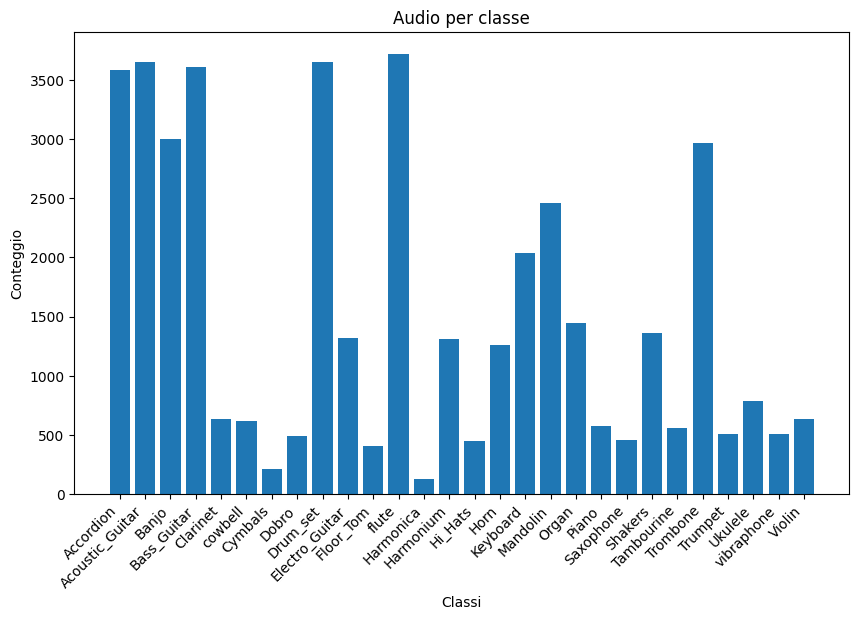

In [8]:
# Plot numero di audio per classe

plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values())
plt.title('Audio per classe')
plt.xlabel('Classi')
plt.ylabel('Conteggio')
plt.xticks(rotation=45, ha='right')
plt.show()

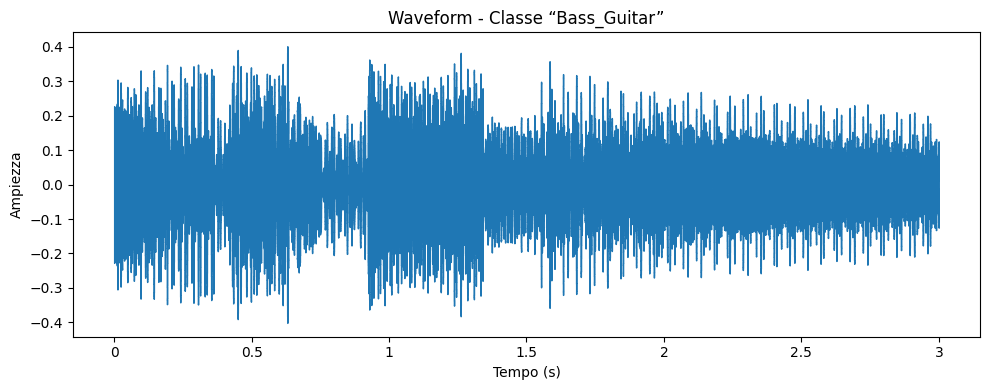

In [14]:
# Visualizzazione e ascolto di un audio random

idx = random.randint(0,len(filepaths)) # indice random
sample_path = filepaths[idx] # audio
sample_label = labels[idx] # label

y, sr = librosa.load(sample_path, sr=None) # load audio
display(Audio(y, rate=sr)) # ascolto

# plot waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform - Classe “{sample_label}”")
plt.xlabel("Tempo (s)")
plt.ylabel("Ampiezza")
plt.tight_layout()
plt.show()

Campione idx=9200, label=Banjo, path=music_dataset\Banjo\279.wav


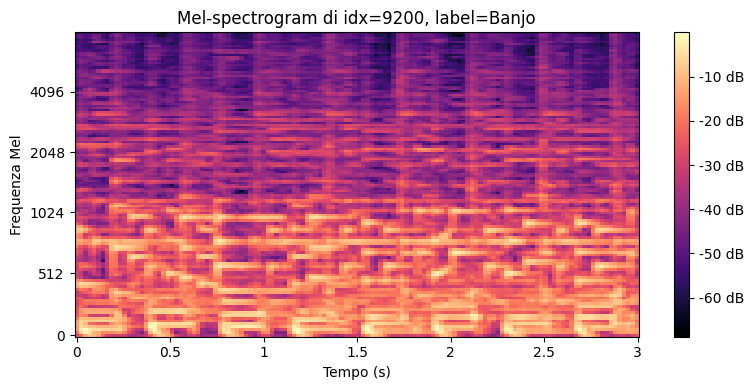

In [42]:
import random
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, display

def play_and_plot_random_sample(sr=None, n_mels=128, fmax=8000, hop_length=512):
    """
    Seleziona a caso un file audio da `filepaths`, ne riproduce l'audio
    e ne disegna il mel-spectrogram con tempo sull'asse x e frequenze Mel sull'asse y.

    Si assume che le variabili globali `filepaths` (lista di path) e `labels`
    (lista di etichette) siano già caricate.

    Args:
        sr (int or None): sample rate per il caricamento; None per il valore originale.
        n_mels (int): numero di bande Mel.
        fmax (int): frequenza massima per l’asse Mel.
        hop_length (int): hop length per il framing (in campioni).

    Returns:
        None
    """
    # 1) Scegli un indice casuale
    idx = random.randint(0, len(filepaths) - 1)
    path = filepaths[idx]
    label = labels[idx]

    # 2) Carica l’audio
    y, sr_used = librosa.load(path, sr=sr, mono=True)

    # 3) Riproduci l’audio in notebook
    print(f"Campione idx={idx}, label={label}, path={path}")
    display(Audio(y, rate=sr_used))

    # 4) Calcola mel-spectrogram in dB
    S = librosa.feature.melspectrogram(
        y=y, sr=sr_used,
        n_mels=n_mels,
        hop_length=hop_length,
        fmax=fmax
    )
    S_db = librosa.power_to_db(S, ref=np.max)

    # 5) Plotta lo spettrogramma
    plt.figure(figsize=(8, 4))
    librosa.display.specshow(
        S_db,
        sr=sr_used,
        hop_length=hop_length,
        x_axis='time',
        y_axis='mel',
        fmax=fmax
    )
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel-spectrogram di idx={idx}, label={label}")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Frequenza Mel")
    plt.tight_layout()
    plt.show()

play_and_plot_random_sample()


Campione idx=10249, label=Bass_Guitar, path=music_dataset\Bass_Guitar\1012.wav


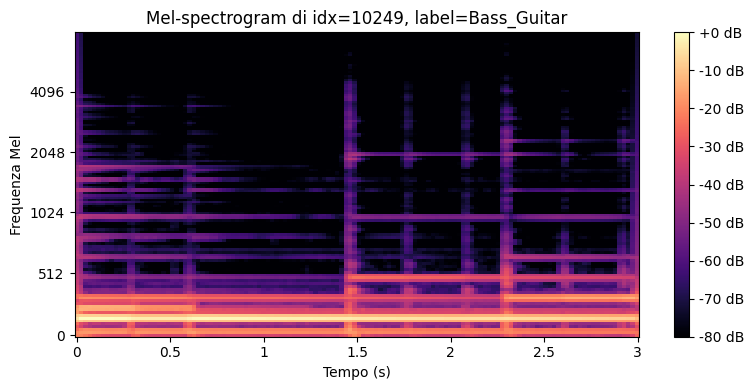

In [ ]:
play_and_plot_random_sample()


# PREPROCESSING

In [58]:
# split 80-10-10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X = filepaths
y = labels
SEED = 22

X, y = shuffle(X, y, random_state=SEED)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=SEED
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=SEED
)

print(f"Train: {len(X_train)} ({len(X_train)/len(X):.1%})")
print(f"Val: {len(X_val)} ({len(X_val)/len(X):.1%})")
print(f"Test: {len(X_test)} ({len(X_test)/len(X):.1%})")

Train: 33848 (80.0%)
Val: 4231 (10.0%)
Test: 4232 (10.0%)


In [7]:
# speedup: carico audio con librosa.load prima a parte

X_train_audio = [librosa.load(path, sr=None, mono=True)[0] for path in X_train]
X_val_audio   = [librosa.load(path, sr=None, mono=True)[0] for path in X_val]
X_test_audio  = [librosa.load(path, sr=None, mono=True)[0] for path in X_test]
# per l'intero dataset ci mette 4 min

In [ ]:
# preprocessing per le X: 1) feature extraction e 2) standardization

# 1) feature extraction (mfcc matrix)
# speedup: estraggo le features in parallelo sfruttando tutti i core disponibili
from joblib import Parallel, delayed

X_train_mel_raw = np.array(Parallel(n_jobs=-1)(delayed(extract_melspectrogram)(y, n_mels=128, fmax=8000)for y in X_train_audio))
X_val_mel_raw = np.array(Parallel(n_jobs=-1)(delayed(extract_melspectrogram)(y, n_mels=128, fmax=8000)for y in X_val_audio))
X_test_mel_raw = np.array(Parallel(n_jobs=-1)(delayed(extract_melspectrogram)(y, n_mels=128, fmax=8000)for y in X_test_audio))
# shape: (#samples, n_mels=128, T=130)
# speedup totale: da 7.5min a 30s+70s

In [ ]:
# 2) standardization (non posso usare lo StandardScaler() perché vuole un array 2D ma noi abbiamo array 3D,
# quindi standardizzo a mano solo sulle ultime 2 dimensioni (n_mfcc,T)
def standardization(X):
    mean = X.mean(axis=(1,2), keepdims=True)
    std  = X.std( axis=(1,2), keepdims=True) + 1e-6
    return (X - mean) / std

X_train_mel = standardization(X_train_mel_raw)
X_val_mel   = standardization(X_val_mel_raw)
X_test_mel  = standardization(X_test_mel_raw)

In [16]:
print("Shapes dopo preprocessing:", X_train_mel.shape, X_val_mel.shape, X_test_mel.shape)

Shapes dopo preprocessing: (33848, 128, 130) (4231, 128, 130) (4232, 128, 130)


In [ ]:
# siccome la feature extration è molto lunga, le salvo in un file (savez serve x salvare piu array), 2GB
np.savez("mel.npz",
         X_train=X_train_mel,
         X_val=X_val_mel,
         X_test=X_test_mel)

In [59]:
# carico features già estratte (ci mette 3s)
data = np.load("mel.npz", allow_pickle=True)
X_train_mel = data["X_train"]
X_val_mel   = data["X_val"]
X_test_mel  = data["X_test"]

In [60]:
# preprocessing per le y: ohe (le y sono categorical: es. "Violin")

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False, handle_unknown='error')

y_train_ohe = ohe.fit_transform(np.array(y_train).reshape(-1, 1))
y_val_ohe   = ohe.transform(np.array(y_val).reshape(-1, 1))
y_test_ohe  = ohe.transform(np.array(y_test).reshape(-1, 1))

In [ ]:
# Preparazione dataset (non serve più)

X = []
Y = []

for path, label in zip(filepaths, labels):
    try:
        mel = extract_melspectrogram(path)
        img = Image.fromarray(mel).resize(IMG_SIZE)
        img = np.array(img)

        if img.shape != (128, 128):
            continue

        X.append(img)
        Y.append(label)
    except Exception as e:
        print(f"Errore su {path.name}: {e}")

X = np.array(X)
Y = np.array(Y)

# ci mette 7.5 min

# MODEL

In [61]:
# aggiungo una dim
X_train_mel = X_train_mel[..., np.newaxis]  # (n_train, 40, T, 1)
X_val_mel   = X_val_mel[...,   np.newaxis]  # (n_val,   40, T, 1)
X_test_mel  = X_test_mel[...,  np.newaxis]  # (n_test,  40, T, 1)

# input che dobbiamo passare alla rete è la dim di un singolo campione ovviamente
input_shape = X_train_mel.shape[1:]  # (128, T, 1)

num_classes = len(set(y_train)) # 28 classi

In [62]:
# classica cnn, ma aggiungo batch_norm () che fanno la differenza
model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [63]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 130, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 128, 130, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 65, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 65, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 65, 64)       256       
 hNormalization)                                                 
                                                        

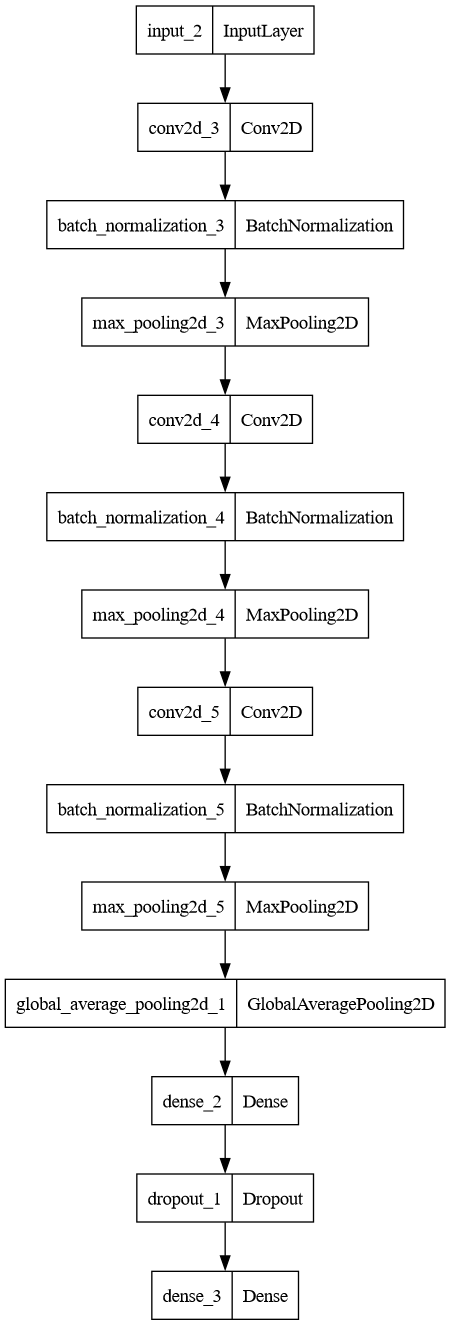

In [38]:
plot_model(model)

In [65]:
# class imbalance: peso di più classi più rare 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
y_train_int = LabelEncoder().fit_transform(y_train)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)

class_weights_dict = dict(enumerate(class_weights))

In [66]:
import tensorflow as tf

print("✅ TensorFlow version:", tf.__version__)
print("🖥️ GPU rilevate:", tf.config.list_physical_devices('GPU'))

if tf.config.list_physical_devices('GPU'):
    print("✅ La GPU è attiva e disponibile! 🚀")
else:
    print("❌ Nessuna GPU disponibile.")

✅ TensorFlow version: 2.10.1
🖥️ GPU rilevate: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ La GPU è attiva e disponibile! 🚀


In [67]:
es = EarlyStopping(
    monitor='val_loss',
    patience=5, # mi fermo se per 5 epochs non miglioro
    restore_best_weights=True # ripristino pesi migliori (prima di overfittare)
)

mc = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss',
    save_best_only=True # salvo solo il modello con val_loss migliore
)

In [68]:
# step aggiuntivo, per evitare InternalError(), per non saturare la RAM

import tensorflow as tf

# Forza la creazione dei tensori costanti sulla CPU
with tf.device('/CPU:0'):
    train_ds = tf.data.Dataset.from_tensor_slices((X_train_mel, y_train_ohe))
    val_ds   = tf.data.Dataset.from_tensor_slices((X_val_mel,   y_val_ohe))
    test_ds  = tf.data.Dataset.from_tensor_slices((X_test_mel,  y_test_ohe))

BATCH_SIZE=16

train_ds = (
    train_ds
    .shuffle(buffer_size=1024, seed=SEED)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [28]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[es, mc],  # callbacks
    class_weight=class_weights_dict # peso x risolvere class imbalance
)

Epoch 1/100
2116/2116 [==============================] - 82s 38ms/step - loss: 1.4508 - accuracy: 0.6294 - val_loss: 1.1761 - val_accuracy: 0.6277
Epoch 2/100
2116/2116 [==============================] - 70s 33ms/step - loss: 0.7385 - accuracy: 0.8027 - val_loss: 0.7448 - val_accuracy: 0.7514
Epoch 3/100
2116/2116 [==============================] - 68s 32ms/step - loss: 0.5096 - accuracy: 0.8621 - val_loss: 0.4754 - val_accuracy: 0.8525
Epoch 4/100
2116/2116 [==============================] - 69s 32ms/step - loss: 0.3910 - accuracy: 0.8920 - val_loss: 0.2275 - val_accuracy: 0.9324
Epoch 5/100
2116/2116 [==============================] - 69s 33ms/step - loss: 0.3232 - accuracy: 0.9124 - val_loss: 0.2490 - val_accuracy: 0.9203
Epoch 6/100
2116/2116 [==============================] - 69s 32ms/step - loss: 0.2796 - accuracy: 0.9210 - val_loss: 0.2353 - val_accuracy: 0.9305
Epoch 7/100
2116/2116 [==============================] - 69s 33ms/step - loss: 0.2348 - accuracy: 0.9339 - val_loss: 0

In [ ]:
model.save('final_model.h5')

In [69]:
model = load_model('CNN_mel.h5') # se vuoi usare modello sul mini-dataset (mfcc)

# RESULTS

In [70]:
test_loss, test_acc = model.evaluate(test_ds)

265/265 [==============================] - 5s 8ms/step - loss: 0.0852 - accuracy: 0.9787


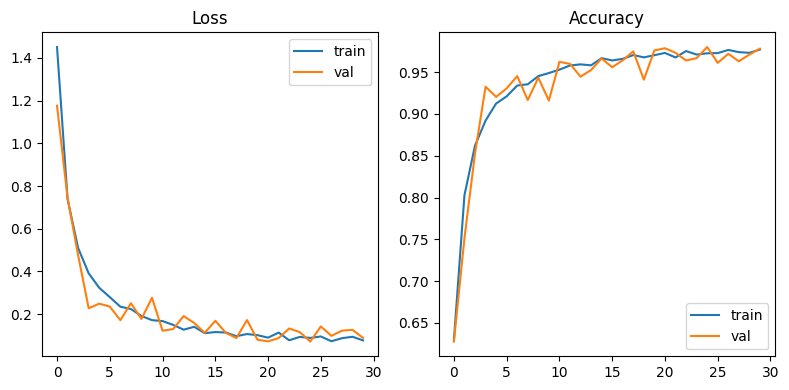

In [32]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [71]:
y_pred_prob = model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_ohe, axis=1)

265/265 [==============================] - 2s 6ms/step


In [34]:
report = classification_report(y_true, y_pred, target_names=sorted(set(labels)))
print("Classification Report:\n")
print(report)

Classification Report:

                 precision    recall  f1-score   support

      Accordion       0.97      0.97      0.97       358
Acoustic_Guitar       0.99      0.97      0.98       366
          Banjo       0.99      0.98      0.99       300
    Bass_Guitar       0.99      1.00      1.00       362
       Clarinet       0.98      0.95      0.97        64
        Cymbals       0.58      0.90      0.71        20
          Dobro       1.00      0.98      0.99        48
       Drum_set       1.00      1.00      1.00       365
 Electro_Guitar       0.94      0.96      0.95       132
      Floor_Tom       0.90      0.93      0.91        40
      Harmonica       0.93      1.00      0.96        13
      Harmonium       1.00      0.99      1.00       132
        Hi_Hats       0.93      0.89      0.91        44
           Horn       1.00      1.00      1.00       126
       Keyboard       1.00      1.00      1.00       204
       Mandolin       0.96      0.97      0.97       246
      

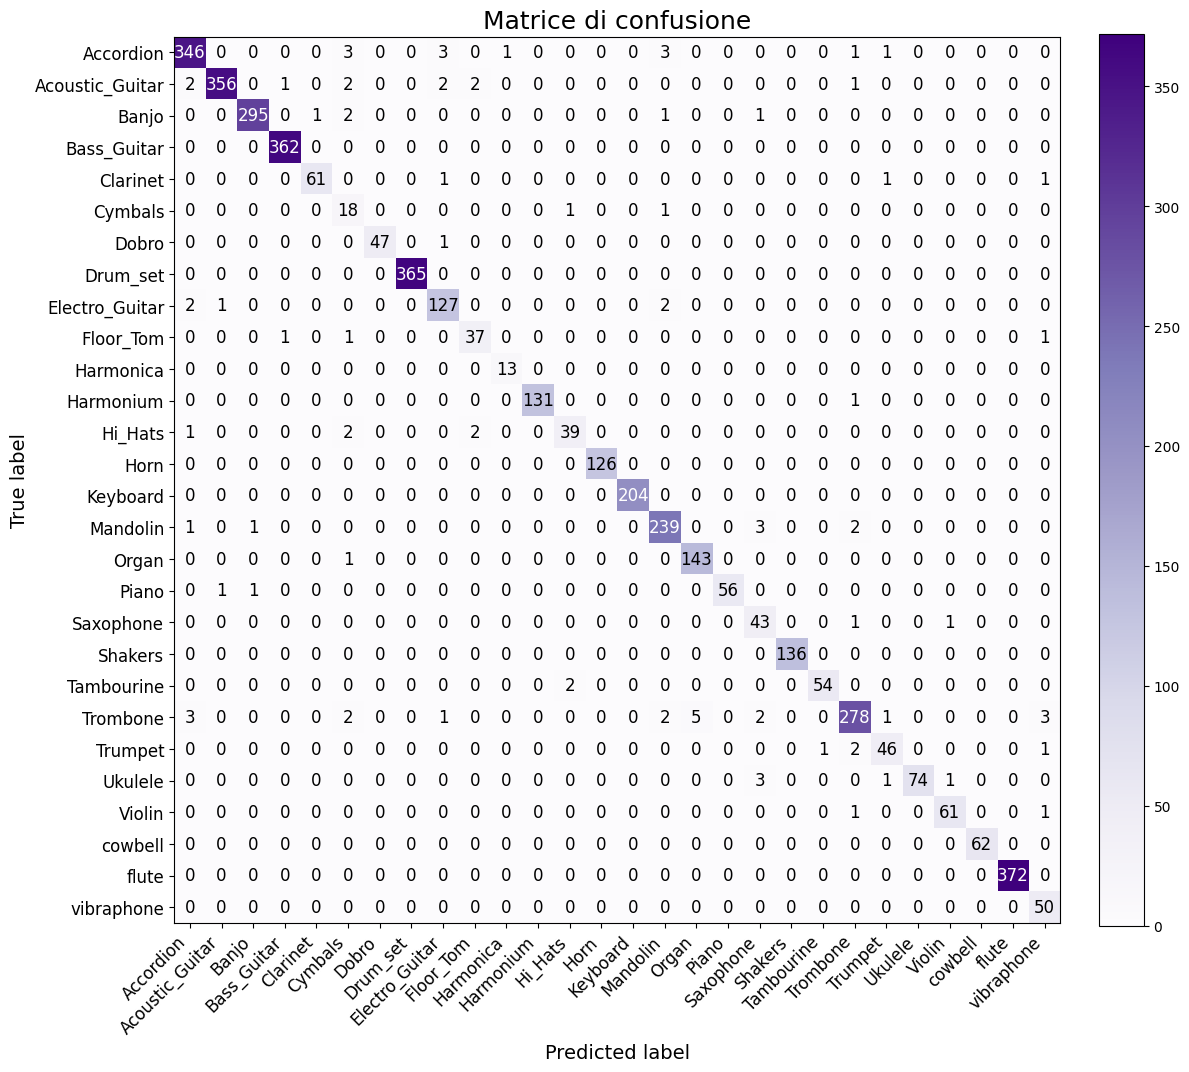

In [35]:
# funzione Confusion Matrix di Dani
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
    plt.title("Matrice di confusione", fontsize=18)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    # Imposta ticks e labels
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=12)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_names, fontsize=12)

    ax.set_ylabel('True label',   fontsize=14)
    ax.set_xlabel('Predicted label', fontsize=14)

    # Annotazioni sui quadrati
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > thresh else "black"
        ax.text(j, i, f"{cm[i, j]}", ha="center", va="center", color=color, fontsize=12)

    plt.tight_layout()
    plt.show()


plot_confusion_matrix(y_true, y_pred, sorted(set(labels)))


In [ ]:
# come si chiama l'ultimo layer convoluzionale della CNN
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv = layer.name
print("Last conv layer:", last_conv)
# potevo anche vederlo da model.summary() e anche vedere che è 32x32 -> heatmap grad-cam sarà 32x32

Last conv layer: conv2d_2


### Explainability: Grad-CAM su Mel-Spectrograms

"Grad-CAM calcola il gradiente dell’output di una classe rispetto alle activation map dell'ultimo layer convoluzionale, pesando ciascuna feature map per l'importanza media del gradiente e generando così una heatmap locale.
Applicandolo ai mel-spectrogram, si ottiene un overlay che evidenzia specifiche bande di frequenza e intervalli temporali su cui il modello si concentra per classificare un suono."

1/1 [==============================] - 0s 16ms/step
Sample index: 1529
True label      : Drum_set
Predicted label : Drum_set



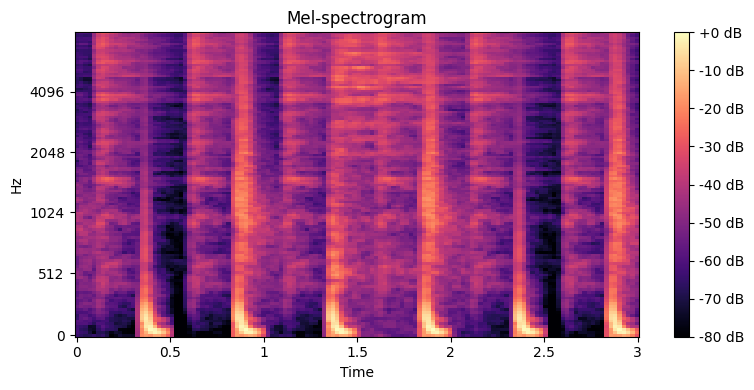

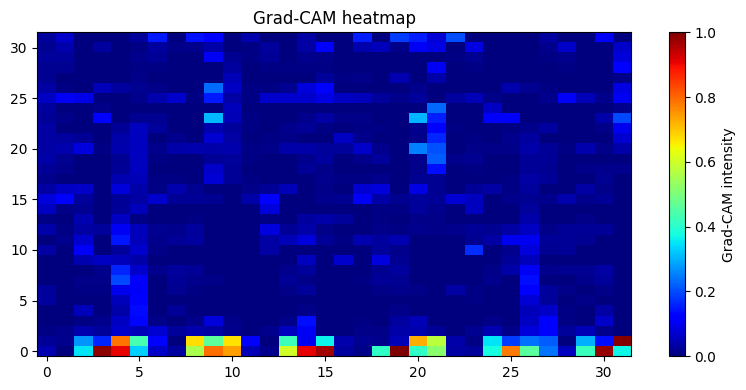

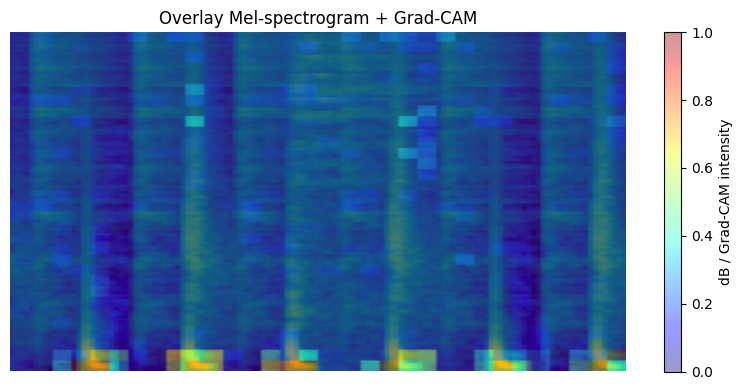

In [153]:
def random_sample_gradcam():
    # 1) Indice random e actual label
    idx = random.randrange(len(X_test))
    filepath   = X_test[idx]
    true_label = y_test[idx]
    
    # 2) Model prediction
    x_input   = X_test_mel[idx:idx+1]  # shape (1,128,T,1)
    pred_prob = model.predict(x_input)
    pred_idx  = np.argmax(pred_prob, axis=1)[0]
    class_names = sorted(set(labels))
    pred_label  = class_names[pred_idx]

    print(f"Sample index: {idx}")
    print(f"True label      : {true_label}")
    print(f"Predicted label : {pred_label}\n")
    
    # 3) Play sound
    y_audio, sr_used = librosa.load(filepath, mono=True)
    display(Audio(y_audio, rate=sr_used))
    
    # 4) Mel-spectrogram originale
    S = librosa.feature.melspectrogram(y=y_audio, sr=sr_used, n_mels=128, hop_length=512, fmax=8000)
    S_db = librosa.power_to_db(S, ref=np.max)
    # plot spectrogram
    plt.figure(figsize=(8, 4))
    librosa.display.specshow(
        S_db, sr=sr_used, hop_length=512,
        x_axis='time', y_axis='mel', fmax=8000
    )
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel-spectrogram")
    plt.tight_layout()
    plt.show()
    
    # 5) Grad-CAM
    last_conv = 'conv2d_2'  # nome dell'ultimo layer Conv2D della CNN
    grad_model = tf.keras.models.Model( # modello che returns sia attivazioni dell'ultimo conv2d, sia output finale di classificazione
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outs, preds = grad_model(x_input)
        loss = preds[:, pred_idx] # prob della predicted label usata come loss di riferimento
    grads = tape.gradient(loss, conv_outs)             # calcolo dei gradienti
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)) # average pooling sui gradienti
    # converto in NumPy e genero heatmap
    conv_outs, pooled_grads = conv_outs[0].numpy(), pooled_grads.numpy()
    heatmap = np.zeros(conv_outs.shape[:2], dtype=np.float32)
    for i in range(pooled_grads.shape[0]):
        heatmap += pooled_grads[i] * conv_outs[:, :, i] # moltiplico ogni activation map per il suo peso
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max() # normalizzo risultato
    # plot heatmap
    plt.figure(figsize=(8, 4))
    plt.imshow(heatmap, aspect='auto', origin='lower', cmap='jet')
    plt.colorbar(label='Grad-CAM intensity')
    plt.title("Grad-CAM heatmap")
    plt.tight_layout()
    plt.show()
    
    # 6) Plot grad-cam + mel-spectrogram
    
    heatmap_resized = cv2.resize(heatmap, (S_db.shape[1], S_db.shape[0]), interpolation=cv2.INTER_NEAREST) # resize heatmap x renderla compatibile con mel-spectrogram
    plt.figure(figsize=(8, 4))
    plt.imshow(S_db, aspect='auto', origin='lower') # mel-spectrogram
    plt.imshow(heatmap_resized, cmap='jet', alpha=0.4, origin='lower', aspect='auto') # heatmap
    plt.axis('off') # non plotto gli assi per non creare confusione
    plt.colorbar(label='dB / Grad-CAM intensity')
    plt.title("Overlay Mel-spectrogram + Grad-CAM")
    plt.tight_layout()
    plt.show()

random_sample_gradcam()

1/1 [==============================] - 0s 20ms/step
Sample index: 3006
True label      : Trumpet
Predicted label : Trumpet



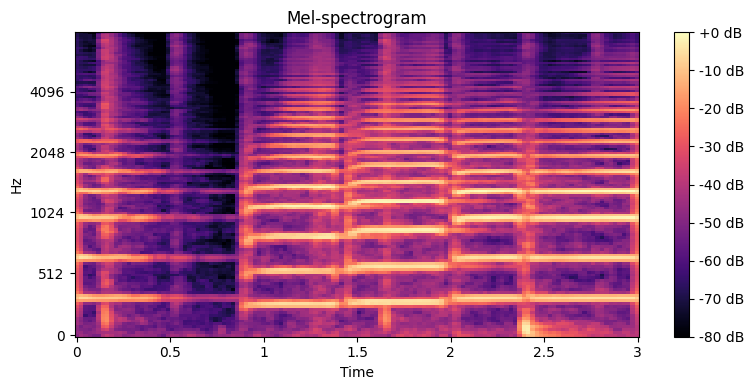

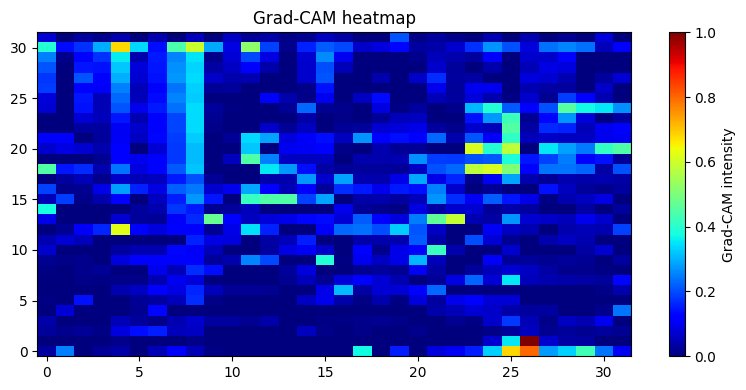

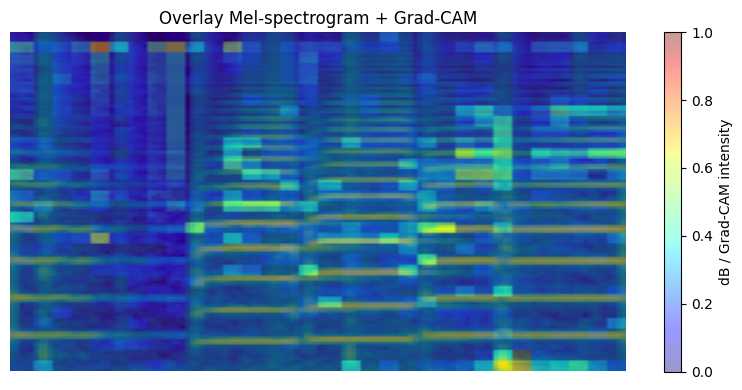

In [154]:
# esempio 2
random_sample_gradcam()

1/1 [==============================] - 0s 16ms/step
Sample index: 1294
True label      : Trombone
Predicted label : Trombone



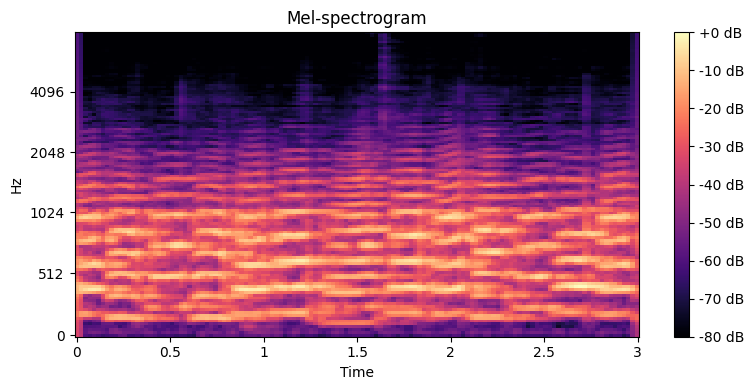

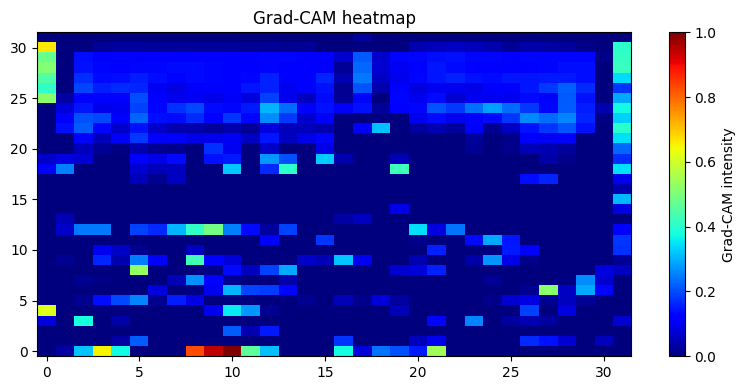

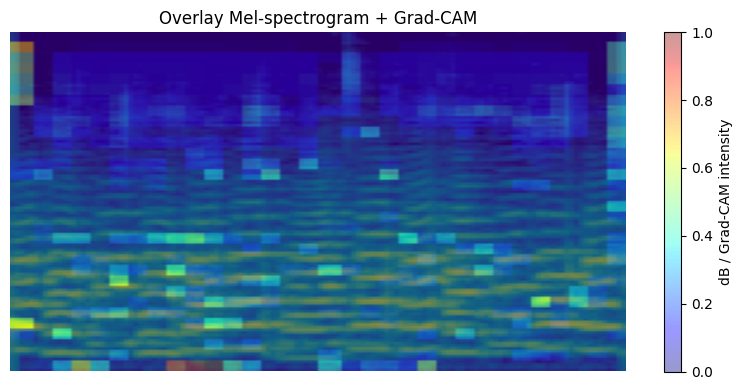

In [181]:
# esempio 3
random_sample_gradcam()

1/1 [==============================] - 0s 15ms/step
Sample index: 1191
True label      : Banjo
Predicted label : Banjo



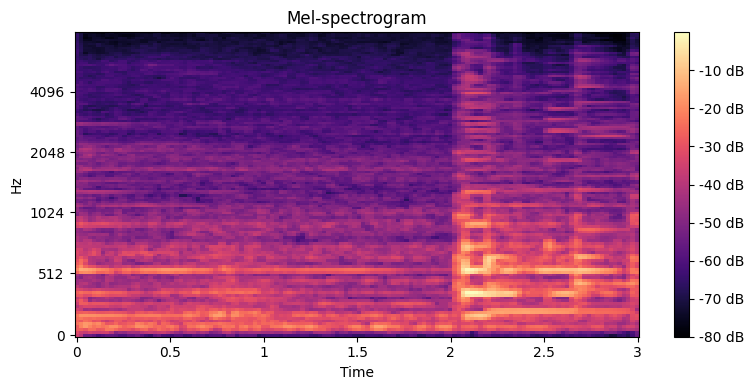

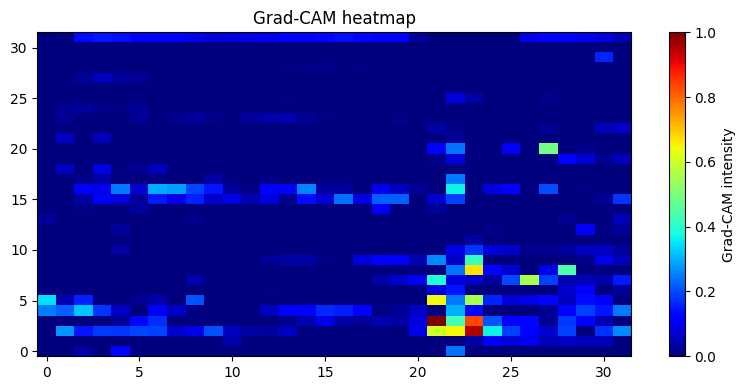

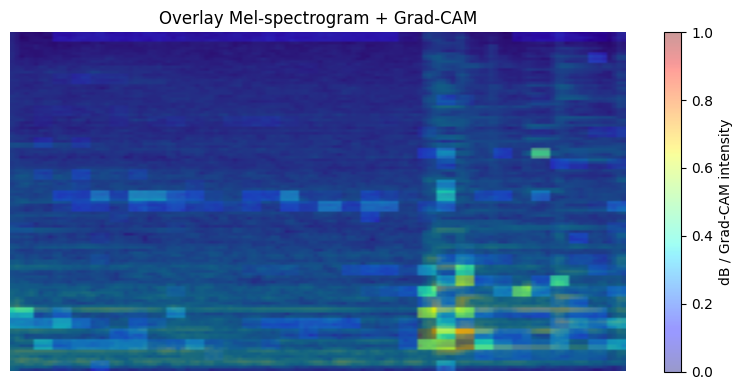

In [190]:
# esempio 4
random_sample_gradcam()

1/1 [==============================] - 0s 15ms/step
Sample index: 1172
True label      : Floor_Tom
Predicted label : Floor_Tom



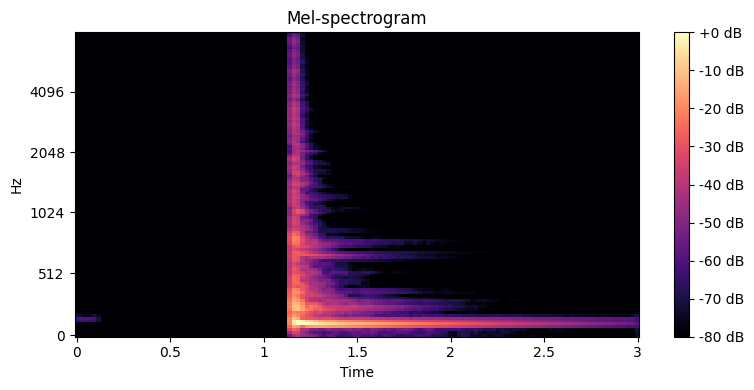

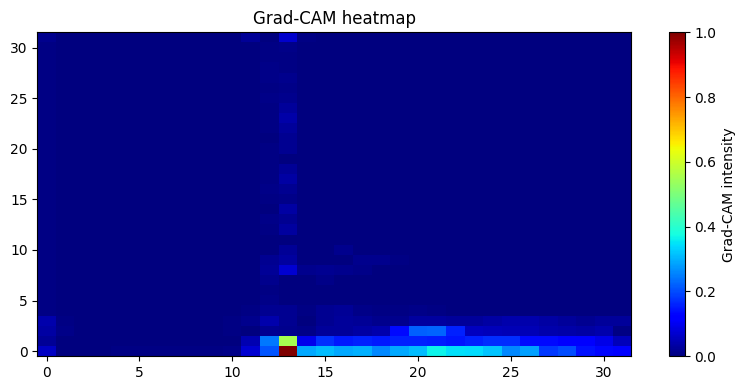

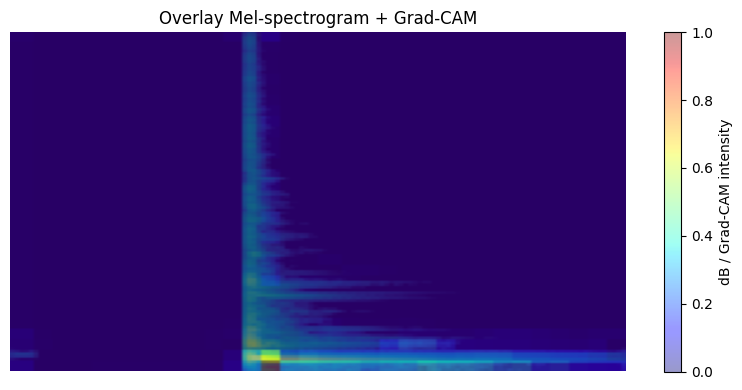

In [ ]:
# esempio 5
random_sample_gradcam()